# 05 High-dimensional Bayesian Workflow, <br> with applications to SARS-CoV-2 strains

In [9]:
from collections import defaultdict
from pprint import pprint
import functools
import math
import os
import torch
import pyro
import pyro.distributions as D
import pyro.poutine as poutine
from pyro.distributions import constraints as C
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import (
    AutoDelta,
    AutoNormal,
    AutoMultivariateNormal,
    AutoLowRankMultivariateNormal,
    AutoGuideList,
    init_to_feasible,
)
from pyro.infer.reparam import AutoReparam, LocScaleReparam
from pyro.nn.module import PyroParam
from pyro.optim import ClippedAdam
from pyro.ops.special import sparse_multinomial_likelihood
import matplotlib.pyplot as plt

### Clean de data

In [10]:
from pyro.contrib.examples.nextstrain import load_nextstrain_counts
dataset = load_nextstrain_counts()

def summarize(x, name=""):
    if isinstance(x, dict):
        for k, v in sorted(x.items()):
            summarize(v, name + "." + k if name else k)
    elif isinstance(x, torch.Tensor):
        print(f"{name}: {type(x).__name__} of shape {tuple(x.shape)} on {x.device}")
    elif isinstance(x, list):
        print(f"{name}: {type(x).__name__} of length {len(x)}")
    else:
        print(f"{name}: {type(x).__name__}")
summarize(dataset)

counts: Tensor of shape (27, 202, 1316) on cpu
features: Tensor of shape (1316, 2634) on cpu
lineages: list of length 1316
locations: list of length 202
mutations: list of length 2634
sparse_counts.index: Tensor of shape (3, 57129) on cpu
sparse_counts.total: Tensor of shape (27, 202) on cpu
sparse_counts.value: Tensor of shape (57129,) on cpu
start_date: datetime
time_step_days: int


$$ \frac{L}{1 + e^{-k(x-x_0)}} $$

In [31]:
def model(dataset, predict=None):
    features = dataset['features']
    counts = dataset['counts']
    sparse_counts = dataset['sparse_counts']
    assert features.shape[0] == counts.shape[-1]
    S, M = features.shape 
    T, P, S = counts.shape
    
    time = torch.arange(float(T)) * dataset['time_step_days'] / 5.5
    time -= time.mean()
    
    strain_plate = pyro.plate('strain', S, dim=-1)
    place_plate = pyro.plate('place', P, dim=-2)
    time_plate = pyro.plate('time', T, dim=-3)
    
    # Model as multivariate logistic growth
    rate_scale = pyro.sample('rate_scale', D.LogNormal(-4, 2))
    init_scale = pyro.sample('init_scale', D.LogNormal(0, 2))
    
    with pyro.plate('mutation', M, dim=-1):
        coef = pyro.sample('coef', D.Laplace(0, 0.5))
    with strain_plate:
        rate_loc = pyro.deterministic('rate_loc', 0.01 * coef @ features.T)
        with place_plate:
            rate = pyro.sample('rate', D.Normal(rate_loc, rate_scale))
            init = pyro.sample('init', D.Normal(0, init_scale))
            
    if predict is not None:
        return (init + rate * time[predict]).softmax(-1)
        
    logits = (init + rate * time[:, None, None]).log_softmax(-1)
    
    t, p, s = sparse_counts['index']
    pyro.factor(
        'obs',
        sparse_multinomial_likelihood(
            sparse_counts['total'], logits[t, p, s], sparse_counts['value']
        )
    )

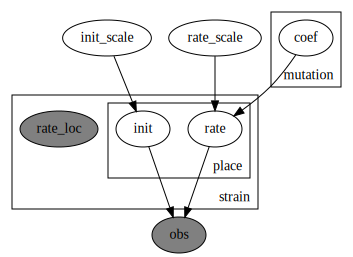

In [32]:
pyro.render_model(model, (dataset, ))

In [47]:
def fit_svi(model, guide, lr=1e-2, numsteps=1000, log_every=100, plot=True):
    pyro.clear_param_store()
    pyro.set_rng_seed(20211205)
    
    num_latents = sum(
        site['value'].numel()
        for name, site in poutine.trace(guide).get_trace(dataset).iter_stochastic_nodes()
        if not site['infer'].get('is_auxiliary')
    )
    
    num_params = sum(p.unconstrained().numel() for p in pyro.get_param_store().values())
    print(f'Found {num_latents} latent variables and {num_params} learnable parameters')
    
    series = defaultdict(list)
    def hook(g, series):
        series.append(torch.linalg.norm(g.reshape(-1), math.inf).item())
    
    for name, value in pyro.get_param_store().named_parameters():
        value.register_hook(
            functools.partial(hook, series=series[name + '_grad'])
        )
   
    optim = ClippedAdam({'lr': lr, 'lrd': 0.1 ** (1 / numsteps)})
    svi = SVI(model, guide, optim, Trace_ELBO())
    numobs = int(dataset['counts'].count_nonzero())
    
    for step in range(numsteps):
        loss = svi.step(dataset) / numobs 
        series['loss'].append(loss)
        median = guide.median()
        for name, value in median.items():
            if value.numel() == 1:
                series[name + '_mean'].append(float(value))
        if step % log_every == (log_every - 1):
            print(f'step: {step+1:4d}, loss: {loss:.6f}')
            
    if not plot:
        return 
    plt.figure(figsize=(12, 12))
    for name, y in series.items():
        if name == 'loss':
            plt.plot(y, 'k--', label=name, zorder=0)
        elif name.endswith('_mean'):
            plt.plot(y, label=name, zorder=-1)
        else:
            plt.plot(y, label=name, alpha=0.5, lw=1, zorder=-2)
    plt.xlabel('SVI step')
    plt.title('Loss, scalar parameters and gradient norms')
    plt.yscale('log')
    plt.xscale('symlog')
    plt.xlim(0, None)
    plt.legend(loc='best', fontsize=8)
    plt.tight_layout()
    plt.show()
    plt.close()

Found 538452 latent variables and 1068600 learnable parameters
step:  100, loss: 63.682885
step:  200, loss: 44.583217
step:  300, loss: 34.946432
step:  400, loss: 30.401294
step:  500, loss: 27.571218
step:  600, loss: 25.489179
step:  700, loss: 23.886949
step:  800, loss: 22.758826
step:  900, loss: 21.923090
step: 1000, loss: 21.242480


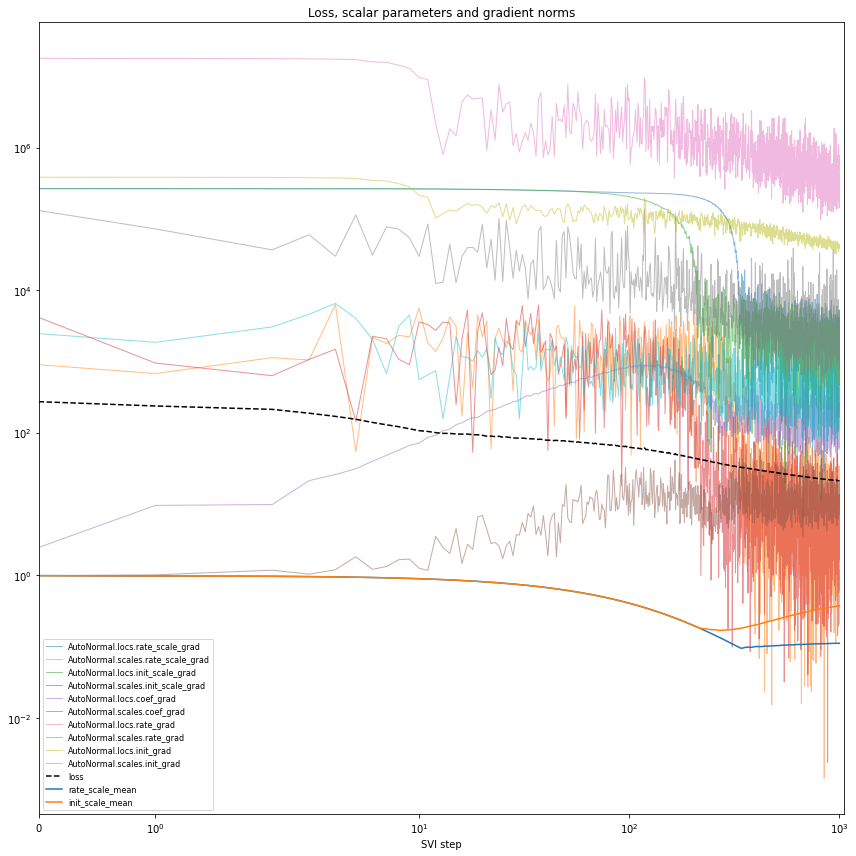

In [48]:
guide = AutoNormal(model, init_scale=0.01)
fit_svi(model, guide)

In [49]:
def mae(true_counts, pred_probs):
    pred_counts = pred_probs * true_counts.sum(-1, True)
    error = (true_counts - pred_counts).abs().sum(-1)
    total = true_counts.sum(-1).clamp(min=1)
    return (error / total).mean().item()

def evaluate(model, guide, nparticles=100, location='USA / Massachusetts', time=-2):
    with torch.no_grad(), poutine.mask(mask=False):
        with pyro.plate('particle', nparticles, dim=-3):
            guide_trace = poutine.trace(guide).get_trace(dataset)
            probs = poutine.replay(model, guide_trace)(dataset, predict=time)
        probs = probs.squeeze().mean(0)
        true_counts = dataset['counts'][time]
        global_mae = mae(true_counts, probs)
        i = dataset['locations'].index(location)
        local_mae = mae(true_counts[i], probs[i])
        return {'MAE (global)': global_mae, f'MAE ({location})': local_mae}

In [50]:
pprint(evaluate(model, guide))

{'MAE (USA / Massachusetts)': 0.26094526052474976,
 'MAE (global)': 0.22647880017757416}


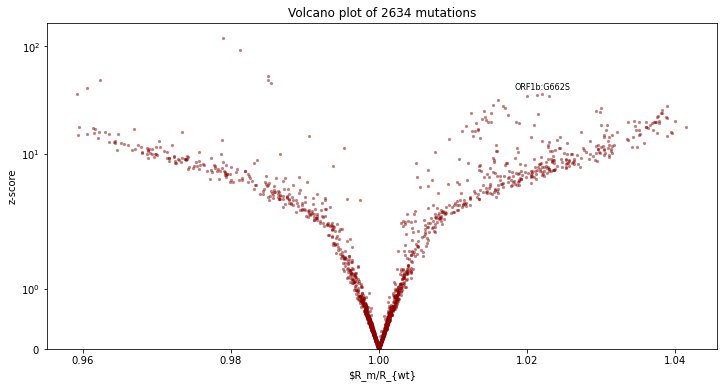

In [51]:
def plot_volcano(guide, nparticles=100):
    with torch.no_grad(), poutine.mask(mask=False):
        with pyro.plate('particle', nparticles, dim=-3):
            trace = poutine.trace(guide).get_trace(dataset)
            trace = poutine.trace(poutine.replay(model, trace)).get_trace(dataset, -1)
            coef = trace.nodes['coef']['value']
    
    coef = coef.squeeze() * 0.01
    mean = coef.mean(0)
    std = coef.std(0)
    z_score = mean.abs() / std 
    effect_size = mean.exp().numpy()
    
    plt.figure(figsize=(12, 6))
    plt.scatter(effect_size, z_score.numpy(), lw=0, s=10, alpha=0.5, color='darkred')
    plt.yscale('symlog')
    plt.ylim(0, None)
    plt.xlabel('$R_m/R_{wt}')
    plt.ylabel('z-score')
    i = int((mean / std).max(0).indices)
    plt.text(effect_size[i], z_score[i] * 1.1, dataset['mutations'][i], ha='center', fontsize=8)
    plt.title(f'Volcano plot of {len(mean)} mutations')
    plt.show()
    plt.close()
    
    
plot_volcano(guide)    

Initialization heuristic

In [52]:
def init_loc_fn(site):
    shape = site['fn'].shape()
    if site['name'].endswith('_scale'):
        return torch.ones(shape)
    if site['name'] == 'coef':
        return torch.randn(shape).sub_(0.5).mul(0.01)
    if site['name'] == 'rate':
        return torch.zeros(shape)
    if site['name'] == 'init':
        return dataset['counts'].mean(0).add(0.01).log()
    raise NotImplementedError(f"TODO: initialize latent variable {site['name']}")

Found 538452 latent variables and 1068600 learnable parameters
step:  100, loss: 45.481778
step:  200, loss: 31.225099
step:  300, loss: 24.604530
step:  400, loss: 20.730221
step:  500, loss: 18.468204
step:  600, loss: 17.107718
step:  700, loss: 16.249239
step:  800, loss: 15.820307
step:  900, loss: 15.899462
step: 1000, loss: 15.414604


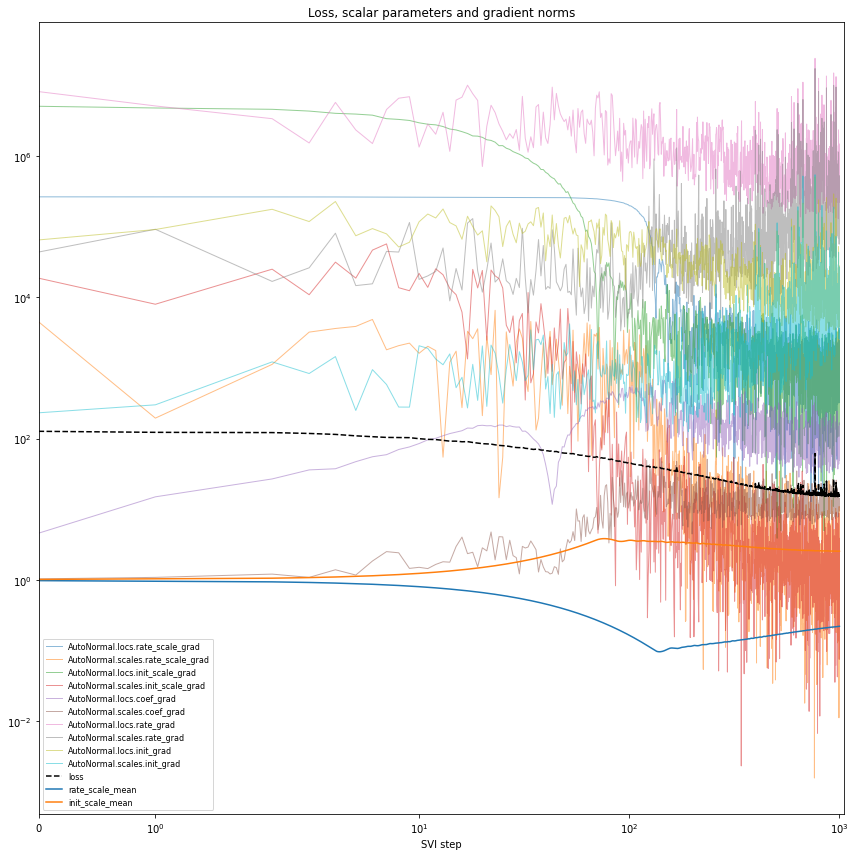

{'MAE (USA / Massachusetts)': 0.2724998891353607,
 'MAE (global)': 0.2267693430185318}


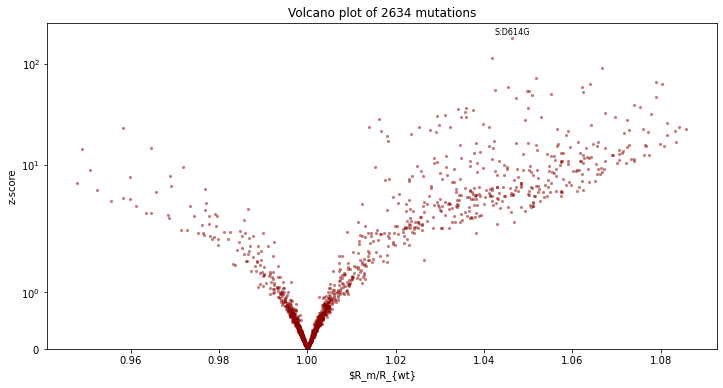

In [53]:
guide = AutoNormal(model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(model, guide, lr=0.02)
pprint(evaluate(model, guide))
plot_volcano(guide)

Reparametrize the model

Found 538452 latent variables and 1068602 learnable parameters
step:  100, loss: 20.134950
step:  200, loss: 10.821239
step:  300, loss: 10.037629
step:  400, loss: 9.433248
step:  500, loss: 9.499441
step:  600, loss: 8.977368
step:  700, loss: 9.025706
step:  800, loss: 8.584875
step:  900, loss: 8.636048
step: 1000, loss: 8.901520


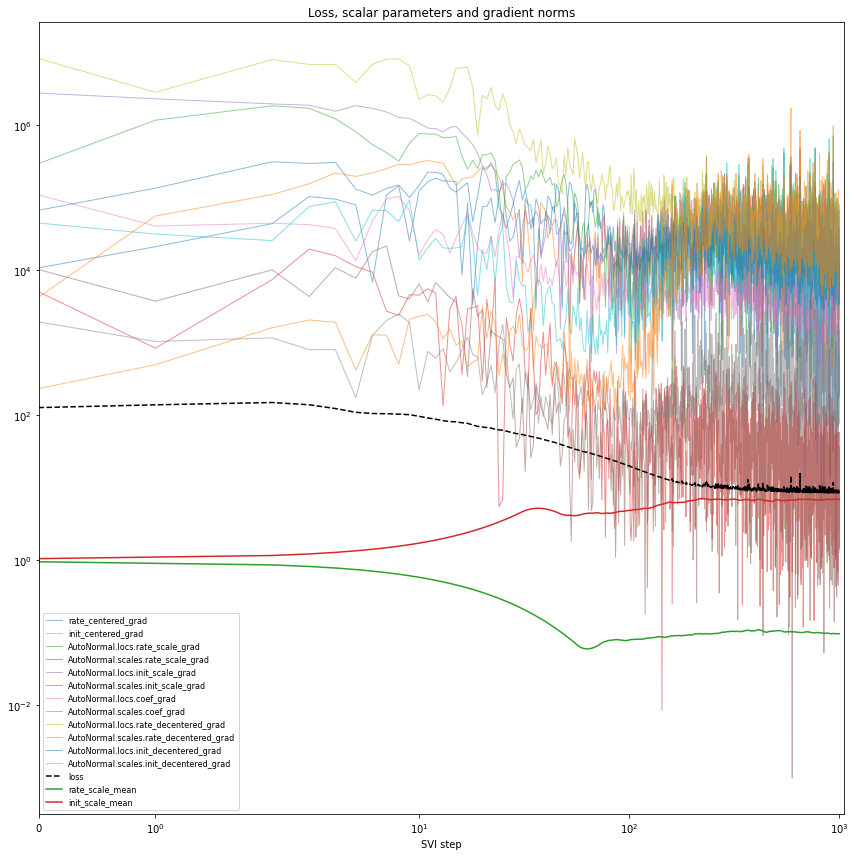

{'MAE (USA / Massachusetts)': 0.12934577465057373,
 'MAE (global)': 0.17269591987133026}


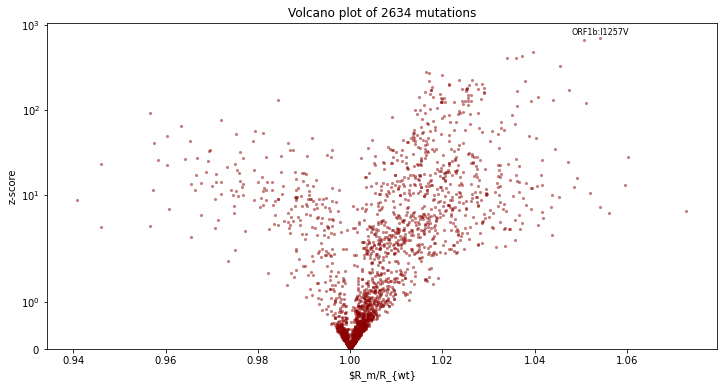

In [54]:
reparam_model = poutine.reparam(model, config={'rate': LocScaleReparam(), 'init': LocScaleReparam()})
guide = AutoNormal(reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01)
fit_svi(reparam_model, guide, lr=0.05)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)

Customize the variational family <br>

1 - `AutoNormal` <br>
2 - `AutoLowRankMultivariateNormal` (`AutoMultivariateNormal` ~ 100) <br>
3 - `AutoGuideList`

In [58]:
from time import time


reparam_model = poutine.reparam(model, config={'rate': LocScaleReparam(), 'init': LocScaleReparam()})
guide = AutoLowRankMultivariateNormal(reparam_model, init_loc_fn=init_loc_fn, init_scale=0.01, rank=100)
since = time()
fit_svi(reparam_model, guide, lr=0.05, numsteps=1, plot=False)
print(time() - since)
# pprint(evaluate(reparam_model, guide))
# plot_volcano(guide)

Found 538452 latent variables and 54498602 learnable parameters
3.550060987472534


Found 538452 latent variables and 1202987 learnable parameters
step:  100, loss: 12.680008
step:  200, loss: 9.879407
step:  300, loss: 9.387808
step:  400, loss: 9.357182
step:  500, loss: 9.429374
step:  600, loss: 9.106056
step:  700, loss: 9.563515
step:  800, loss: 9.278316
step:  900, loss: 9.742513
step: 1000, loss: 8.937580


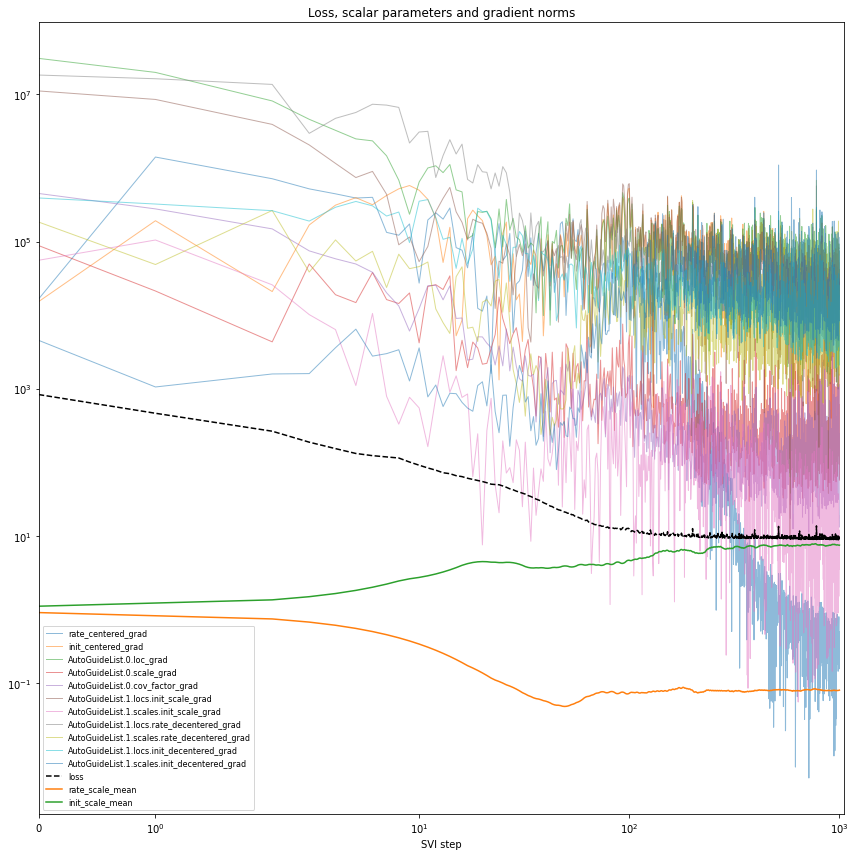

{'MAE (USA / Massachusetts)': 0.10316472500562668,
 'MAE (global)': 0.16741988062858582}


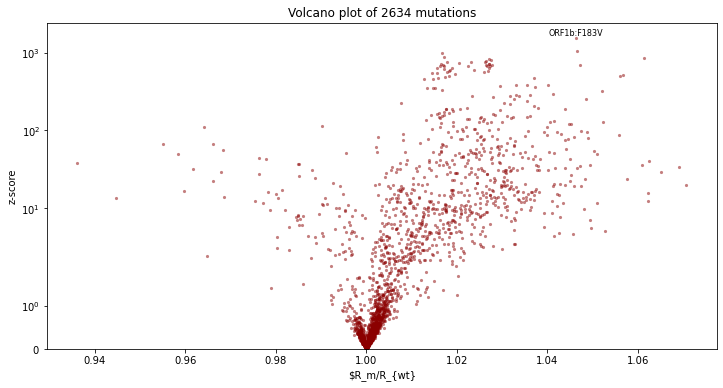

In [60]:
reparam_model = poutine.reparam(model, config={'rate': LocScaleReparam(), 'init': LocScaleReparam()})
guide = AutoGuideList(reparam_model)
mvn_vars = ['coef', 'rate_scale', 'coef_scale']
guide.add(
    AutoLowRankMultivariateNormal(
        poutine.block(reparam_model, expose=mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale=0.01
    )
)
guide.add(
    AutoNormal(
        poutine.block(reparam_model, hide=mvn_vars),
        init_loc_fn=init_loc_fn,
        init_scale=0.01
    )
)
fit_svi(reparam_model, guide, lr=0.1)
pprint(evaluate(reparam_model, guide))
plot_volcano(guide)